In [1]:
import pandas as pd
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import shutil

import numpy as np
from sklearn.preprocessing import LabelEncoder
from dacon_submit_api import dacon_submit_api 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [2]:
%load_ext tensorboard

In [3]:
train = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/movie_attendance/movies_train.csv")
test = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/movie_attendance/movies_test.csv")
submission = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/movie_attendance/submission.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [5]:
train[train.dir_prev_num == 0].isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [6]:
train["dir_prev_bfnum"] = train["dir_prev_bfnum"].fillna(0)
test["dir_prev_bfnum"] = test["dir_prev_bfnum"].fillna(0)
train[train.dir_prev_num == 0].isnull().sum()
test.shape

(243, 11)

In [7]:
features = ["time", "screening_rat", "dir_prev_bfnum", "genre", "dir_prev_num", "num_staff", "num_actor"]
label = ["box_off_num"]
train = train.astype({"box_off_num": "float32"})
X_train, y_train, X_test = train[features], train[label], test[features]

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            243 non-null    int64  
 1   screening_rat   243 non-null    object 
 2   dir_prev_bfnum  243 non-null    float64
 3   genre           243 non-null    object 
 4   dir_prev_num    243 non-null    int64  
 5   num_staff       243 non-null    int64  
 6   num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 13.4+ KB


In [8]:
# 일단은 다 넣어보자. 

categori_col = ["genre", "screening_rat"]

for col in categori_col:
    encoder = LabelEncoder()
    # train
    X_train[col] = encoder.fit_transform(X_train[col])
    
    # 혹시나 test에는 새로운 categori가 생길 것을 대비.
    for label in np.unique(X_test[col]):
        if label not in encoder.classes_:
            encoder.classes_ = np.append(encoder.classes_, label) 
    # test
    X_test[col] = encoder.fit_transform(X_test[col])

X_train.head()


<ipython-input-8-bcd5b224946d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = encoder.fit_transform(X_train[col])
<ipython-input-8-bcd5b224946d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = encoder.fit_transform(X_test[col])


,time,screening_rat,dir_prev_bfnum,genre,dir_prev_num,num_staff,num_actor
0,96,3,0.00,10,0,91,2
1,130,3,1161602.50,2,2,387,3
2,123,1,220775.25,10,4,343,4
3,101,2,23894.00,11,2,20,6
4,108,1,1.00,11,1,251,2


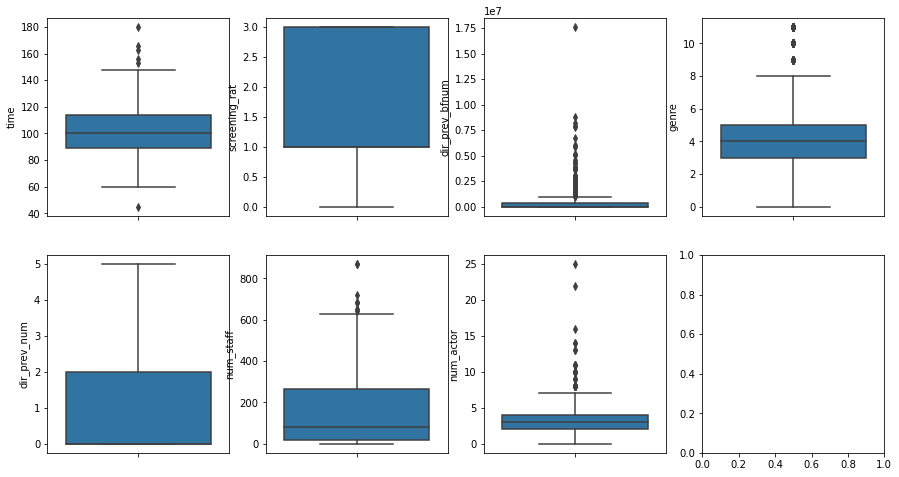

In [9]:
cols = X_train.columns
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

for idx, col in enumerate(cols):
    i = idx // 4
    j = idx % 4
    sns.boxplot(y=col, data=X_train, ax=ax[i][j])
    
    


In [10]:
# 정규화
mm = MinMaxScaler()
sc = StandardScaler()
rc = RobustScaler()
cols = X_train.columns.tolist()
for col in cols:
    X_train[col] = rc.fit_transform(X_train.loc[:, col].values.reshape(-1, 1))
    X_test[col] = rc.fit_transform(X_testloc[:, col].values.reshape(-1, 1))


<ipython-input-10-8282c490651b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = rc.fit_transform(X_train[col].values.reshape(-1, 1))
<ipython-input-10-8282c490651b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = rc.fit_transform(X_test[col].values.reshape(-1, 1))
<ipython-input-10-8282c490651b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [72]:
inputs = Input(shape=(X_train.shape[1],))

class RMSE(keras.losses.Loss):
    def __init__(self, name="custom_rmse"):
        super().__init__(name=name)
    
    def call(self, y_true, y_pred):
        rmse = tf.sqrt(tf.math.reduce_mean(tf.square(y_true - y_pred)))
        return rmse

def build_model(inputs):
    layer = Dense(128, activation="tanh", 
                  activity_regularizer=keras.regularizers.l2(0.00001))(inputs)
    layer = Dropout(0.2)(layer)
    
    layer = Dense(64, activation="relu")(layer)
    layer = Dropout(0.2)(layer)
    
    layer = Dense(32, activation="tanh")(layer)
    layer = Dropout(0.2)(layer)
    
    layer = Dense(16, activation="relu")(layer)
    layer = Dropout(0.2)(layer)
    
    layer = Dense(4, activation="linear")(layer)
    layer = Dropout(0.2)(layer)
    
    output = Dense(1, activation="linear")(layer)
    
    model = Model(inputs=inputs, outputs=output)
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=RMSE(), metrics=[keras.metrics.RootMeanSquaredError()])
    return model


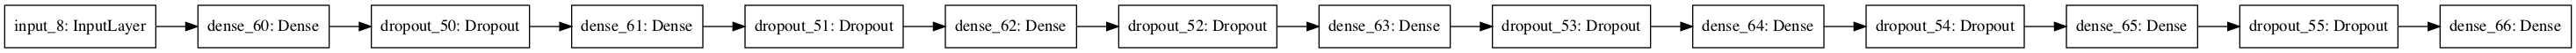

In [73]:
model = build_model(inputs)
keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [74]:
X_train

,time,screening_rat,dir_prev_bfnum,genre,dir_prev_num,num_staff,num_actor
0,-0.16,1.0,0.000000,3.0,0.0,0.034413,-0.5
1,1.20,1.0,3.088205,-1.0,1.0,1.232794,0.0
2,0.92,0.0,0.586947,3.0,2.0,1.054656,0.5
3,0.04,0.5,0.063524,3.5,1.0,-0.253036,1.5
4,0.32,0.0,0.000003,3.5,0.5,0.682186,-0.5
...,...,...,...,...,...,...,...
595,0.44,1.0,0.010190,0.0,0.5,1.730769,2.0
596,1.08,0.0,1.318814,0.0,0.5,0.823887,1.5
597,-0.04,1.0,0.000000,-1.5,0.0,0.163968,0.5
598,0.08,0.0,0.000000,-1.0,0.0,1.410931,0.5


In [75]:
OUTDIR_cp = "./ck/"
OUTDIR_tb = "./movie_train"
cp = ModelCheckpoint(
                    filepath=OUTDIR_cp,
                    mode="min", monitor="val_loss",
                    verbose=1, save_best_only=True)

es = EarlyStopping(
                  monitor="val_loss",
                  min_delta=0.0001,
                  patience=10,
                  verbose=1,
                  mode="min",
                  restore_best_weights=True)



tb = TensorBoard(log_dir=OUTDIR_tb, histogram_freq=1)
shutil.rmtree(path=OUTDIR_cp, ignore_errors=True)
shutil.rmtree(path=OUTDIR_tb, ignore_errors=True)

history = model.fit(x=X_train, y=y_train,
                   epochs=300,
                   batch_size=1,
                   verbose=1,
                   validation_split=0.3,
                   callbacks=[tb, cp, es])

Epoch 1/300
420/420 [==============================] - 1s 1ms/step - loss: 624533.1250 - root_mean_squared_error: 1763580.5000 - val_loss: 902628.6875 - val_root_mean_squared_error: 2352310.7500

Epoch 00001: val_loss improved from inf to 902628.68750, saving model to ./ck/
INFO:tensorflow:Assets written to: ./ck/assets
Epoch 2/300
420/420 [==============================] - 0s 1ms/step - loss: 623755.0625 - root_mean_squared_error: 1763119.7500 - val_loss: 901759.5625 - val_root_mean_squared_error: 2351610.5000

Epoch 00002: val_loss improved from 902628.68750 to 901759.56250, saving model to ./ck/
INFO:tensorflow:Assets written to: ./ck/assets
Epoch 3/300
420/420 [==============================] - 0s 1ms/step - loss: 623050.4375 - root_mean_squared_error: 1762550.8750 - val_loss: 901365.3125 - val_root_mean_squared_error: 2351027.7500

Epoch 00003: val_loss improved from 901759.56250 to 901365.31250, saving model to ./ck/
INFO:tensorflow:Assets written to: ./ck/assets
Epoch 4/300
420/

INFO:tensorflow:Assets written to: ./ck/assets
Epoch 26/300
420/420 [==============================] - 1s 2ms/step - loss: 535215.3750 - root_mean_squared_error: 1602175.6250 - val_loss: 772166.7500 - val_root_mean_squared_error: 2185222.0000

Epoch 00026: val_loss improved from 778418.50000 to 772166.75000, saving model to ./ck/
INFO:tensorflow:Assets written to: ./ck/assets
Epoch 27/300
420/420 [==============================] - 0s 1ms/step - loss: 549206.5000 - root_mean_squared_error: 1638066.3750 - val_loss: 771641.6250 - val_root_mean_squared_error: 2172847.5000

Epoch 00027: val_loss improved from 772166.75000 to 771641.62500, saving model to ./ck/
INFO:tensorflow:Assets written to: ./ck/assets
Epoch 28/300
420/420 [==============================] - 0s 1ms/step - loss: 532041.3750 - root_mean_squared_error: 1599460.2500 - val_loss: 767050.3750 - val_root_mean_squared_error: 2175059.5000

Epoch 00028: val_loss improved from 771641.62500 to 767050.37500, saving model to ./ck/
INFO

420/420 [==============================] - 0s 952us/step - loss: 497733.1875 - root_mean_squared_error: 1540739.3750 - val_loss: 703698.3750 - val_root_mean_squared_error: 2054271.5000

Epoch 00053: val_loss did not improve from 697084.43750
Epoch 54/300
420/420 [==============================] - 0s 959us/step - loss: 485739.0938 - root_mean_squared_error: 1510716.7500 - val_loss: 709750.3750 - val_root_mean_squared_error: 2055276.7500

Epoch 00054: val_loss did not improve from 697084.43750
Epoch 55/300
420/420 [==============================] - 0s 948us/step - loss: 481110.0938 - root_mean_squared_error: 1478119.0000 - val_loss: 709123.0000 - val_root_mean_squared_error: 2048796.8750

Epoch 00055: val_loss did not improve from 697084.43750
Epoch 56/300
420/420 [==============================] - 0s 950us/step - loss: 477426.7812 - root_mean_squared_error: 1475617.6250 - val_loss: 703131.7500 - val_root_mean_squared_error: 2024284.7500

Epoch 00056: val_loss did not improve from 697084

420/420 [==============================] - 0s 1ms/step - loss: 468951.5000 - root_mean_squared_error: 1447897.1250 - val_loss: 693668.7500 - val_root_mean_squared_error: 1993114.7500

Epoch 00083: val_loss did not improve from 682511.75000
Epoch 84/300
420/420 [==============================] - 0s 953us/step - loss: 463778.9375 - root_mean_squared_error: 1452412.2500 - val_loss: 698917.1875 - val_root_mean_squared_error: 1999297.6250

Epoch 00084: val_loss did not improve from 682511.75000
Epoch 85/300
420/420 [==============================] - 0s 1ms/step - loss: 477047.3750 - root_mean_squared_error: 1452671.1250 - val_loss: 700402.7500 - val_root_mean_squared_error: 2014710.6250

Epoch 00085: val_loss did not improve from 682511.75000
Epoch 86/300
420/420 [==============================] - 0s 965us/step - loss: 445013.1875 - root_mean_squared_error: 1394645.0000 - val_loss: 697595.6875 - val_root_mean_squared_error: 1989374.0000

Epoch 00086: val_loss did not improve from 682511.750

In [76]:
%tensorboard --logdir "./movie_train"

Reusing TensorBoard on port 6015 (pid 15693), started 0:31:53 ago. (Use '!kill 15693' to kill it.)

In [77]:
pred = model.predict(X_test)

In [78]:
result = pd.DataFrame(pred)
result[0] = result[0].apply(lambda x: int(x))

In [79]:
submission["box_off_num"] = result[0]
submission

,title,box_off_num
0,용서는 없다,1276786
1,아빠가 여자를 좋아해,366025
2,하모니,1533263
3,의형제,1067211
4,평행 이론,601186
...,...,...
238,해에게서 소년에게,1357
239,울보 권투부,1357
240,어떤살인,3799
241,말하지 못한 비밀,2435


In [63]:
submission.to_csv("./submission/submission_6.csv", index=False)

In [80]:

result = dacon_submit_api.post_submission_file(
'./submission/submission_5.csv', 
'369d8186e100432064ec63e2c634a2b89a5791d577c9b056c4f5e36c999fca14', 
'235536', 
'쵸비 우승 기원', 
'loss: 438932.0000, val_loss: 671834.0625')

{'isSubmitted': True, 'detail': 'Success'}
